# Regression benchmark—rotating MNIST

In [1]:
import os
import re
import jax
import optax
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from time import time
from rebayes.sgd_filter import replay_sgd as rsgd

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2

In [3]:
import flax.linen as nn

In [5]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 1 * std_sim
    ubound = mean_sim + 1 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
def load_output(filename, path):
    filename = os.path.join(path, filename)
    with open(filename, "rb") as f:
        res = pickle.load(f) 
    return res

In [8]:
from rebayes.utils.utils import get_subtree, tree_to_cpu

In [8]:
def tree_shape(tree):
    return jax.tree_map(jnp.shape, tree)

In [14]:
# base_path = "./output/sorted-rotating-mnist/"
base_path = "./output/sorted-rotated-mnist"
# base_path = "./output/rotated-mnist/"

base_path = "/tmp/rebayes"

In [15]:
dataset_name = "rotating-mnist-2-mlp"
# dataset_name = "sorted-rotating-mnist-2-mlp"

filenames = os.listdir(base_path)
filenames = [file for file in filenames if (dataset_name in file)]
# filenames = [file for file in filenames if ("sorted" not in file)]

In [16]:
sorted(filenames)

['rotating-mnist-2-mlp-rank05_lofi.pkl',
 'rotating-mnist-2-mlp-rank05_sgd-rb.pkl',
 'rotating-mnist-2-mlp-rank10_lofi.pkl',
 'rotating-mnist-2-mlp-rank10_sgd-rb.pkl',
 'rotating-mnist-2-mlp-rank15_lofi.pkl',
 'rotating-mnist-2-mlp-rank15_sgd-rb.pkl',
 'rotating-mnist-2-mlp-rank20_lofi.pkl',
 'rotating-mnist-2-mlp-rank20_sgd-rb.pkl',
 'rotating-mnist-2-mlp-rank50_lofi.pkl',
 'rotating-mnist-2-mlp-rank50_sgd-rb.pkl']

In [17]:
regexp = re.compile(rf"{dataset_name}-(\w+)")
agents = [regexp.search(filename)[1] for filename in filenames]

In [18]:
agents_output = {}
agents_res = {}
for i, (agent_name, filename) in enumerate(zip(agents, filenames)):
    res = load_output(filename, base_path)
    agent_name = f"{agent_name}"
    agents_output[agent_name] = res["output"]
    agents_res[agent_name] = res

In [19]:
colors = plt.cm.tab10(np.linspace(0, 1, len(agents) + 1))
colors = plt.cm.tab10(np.arange(len(agents) + 1))
colors = {
    name_agent: color
    for name_agent, color
    in zip(agents + ["sgd-rb"], colors)
}

In [44]:
data = get_subtree(agents_output, "osa-error")
data = tree_to_cpu(data)

data = pd.DataFrame(data)
data.index.name = "n_obs"
data = data.reset_index()

data = data.melt(id_vars="n_obs", var_name="model", value_name="rmse")

In [45]:
models = data["model"]
model_desc = models.str.split("rank(?P<rank>[0-9]+)_", regex=True, expand=True).drop(0, axis=1)
model_desc.columns = ["rank", "agent"]
model_desc["rank"] = model_desc["rank"].astype(int)

data = data.join(model_desc)
data.tail()

,n_obs,model,rmse,rank,agent
49995,4995,rank50_sgd,14.720276,50,sgd
49996,4996,rank50_sgd,9.761643,50,sgd
49997,4997,rank50_sgd,2.026642,50,sgd
49998,4998,rank50_sgd,20.083557,50,sgd
49999,4999,rank50_sgd,9.134277,50,sgd


In [46]:
agents = data.agent.unique()
agents

array(['lofi', 'sgd'], dtype=object)

In [47]:
agents_void = ["lofi_diag", "lofi_orth", "vdekf"]

In [48]:
data = data.query("agent not in @agents_void")

In [49]:
n_obs = data["n_obs"].max()

### Data analysis

In [50]:
dataset_name = "sorted-rotating-mnist-2-mlp"

In [51]:
sorted([key for key in agents_res if "lofi" in key])

['rank05_lofi', 'rank10_lofi', 'rank15_lofi', 'rank20_lofi', 'rank50_lofi']

In [52]:
summary = data.query("n_obs==@n_obs").pivot_table(index="rank", columns="agent", values="rmse")
summary

agent,lofi,sgd
rank,,
5,32.853695,7.860321
10,34.705948,0.067505
15,35.894669,8.758148
20,37.014175,0.074158
50,37.590240,9.134277


In [53]:
hparam_table = []
for key in agents_res:
    if "lofi" in key:
        entry = {
            **agents_res[key]["hparams"]["params"],
            "rank": int(key.lstrip("rank").rstrip("_lofi"))
        }
        hparam_table.append(entry)
    
hparam_table = pd.DataFrame(hparam_table).set_index("rank").sort_index()

In [54]:
hparam_table.join(summary["lofi"])

,dynamics_log_cov,log_dynamics_weights,log_emission_cov,log_inflation,log_init_cov,lofi
rank,,,,,,
5,-80.000000,0.0,0.0,-17.147635,-10.0,32.853695
10,-80.000000,0.0,0.0,-17.115232,-10.0,34.705948
15,-80.000000,0.0,0.0,-17.082087,-10.0,35.894669
20,-58.388297,0.0,0.0,-21.347297,-10.0,37.014175
50,-58.385114,0.0,0.0,-21.339201,-10.0,37.590240


## One-step-ahed

Text(0.5, 0, 'agent memory')

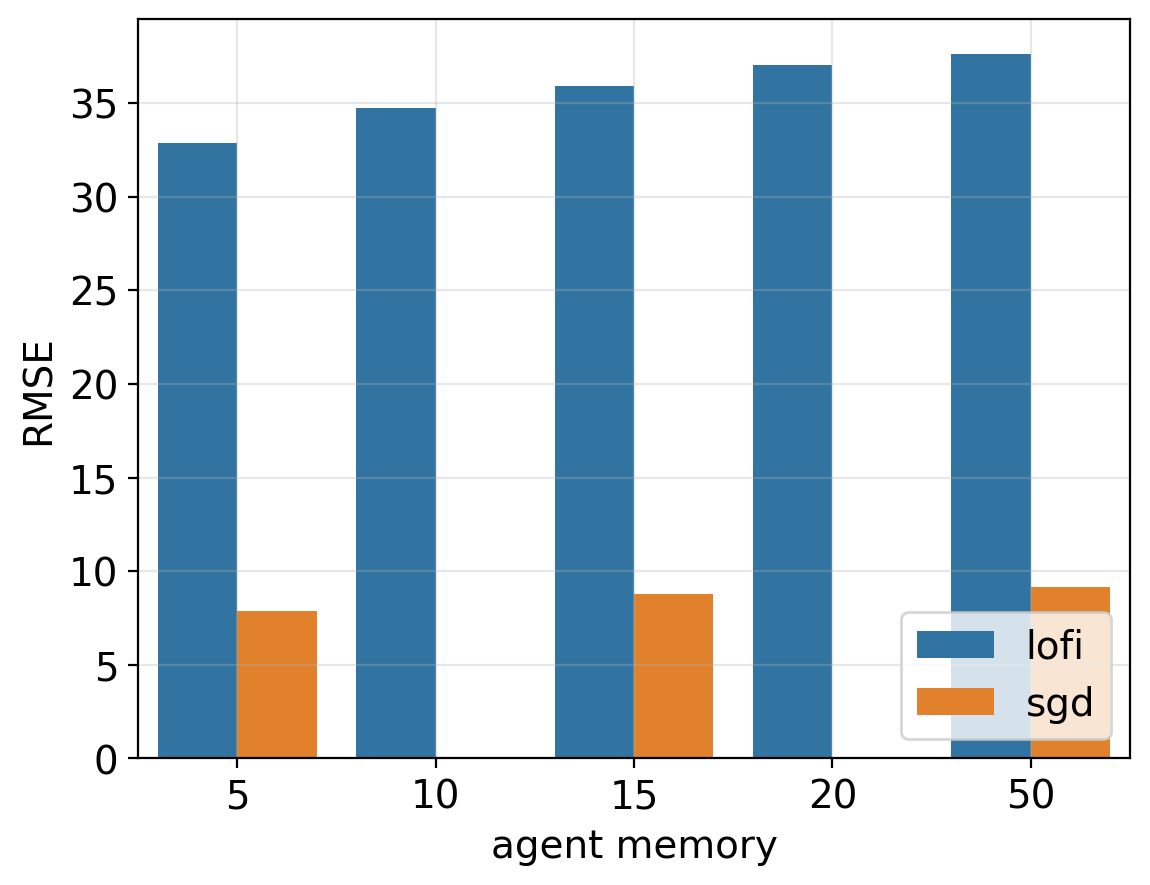

In [55]:
sns.barplot(x="rank", y="rmse", hue="agent", data=data.query("n_obs == @n_obs"))
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.ylabel("RMSE")
plt.xlabel("agent memory")
# plt.savefig(f"output/images/{dataset_name}-final-test-rmse.pdf")

In [56]:
agents = list(data["agent"].unique())
cmap = plt.cm.tab10
colors = {
    agent: cmap(i)
    for i, agent in enumerate(agents)
}

In [57]:
rank_unique = data["rank"].unique()

Text(0.5, 1.0, 'One-step-ahead pp-error')

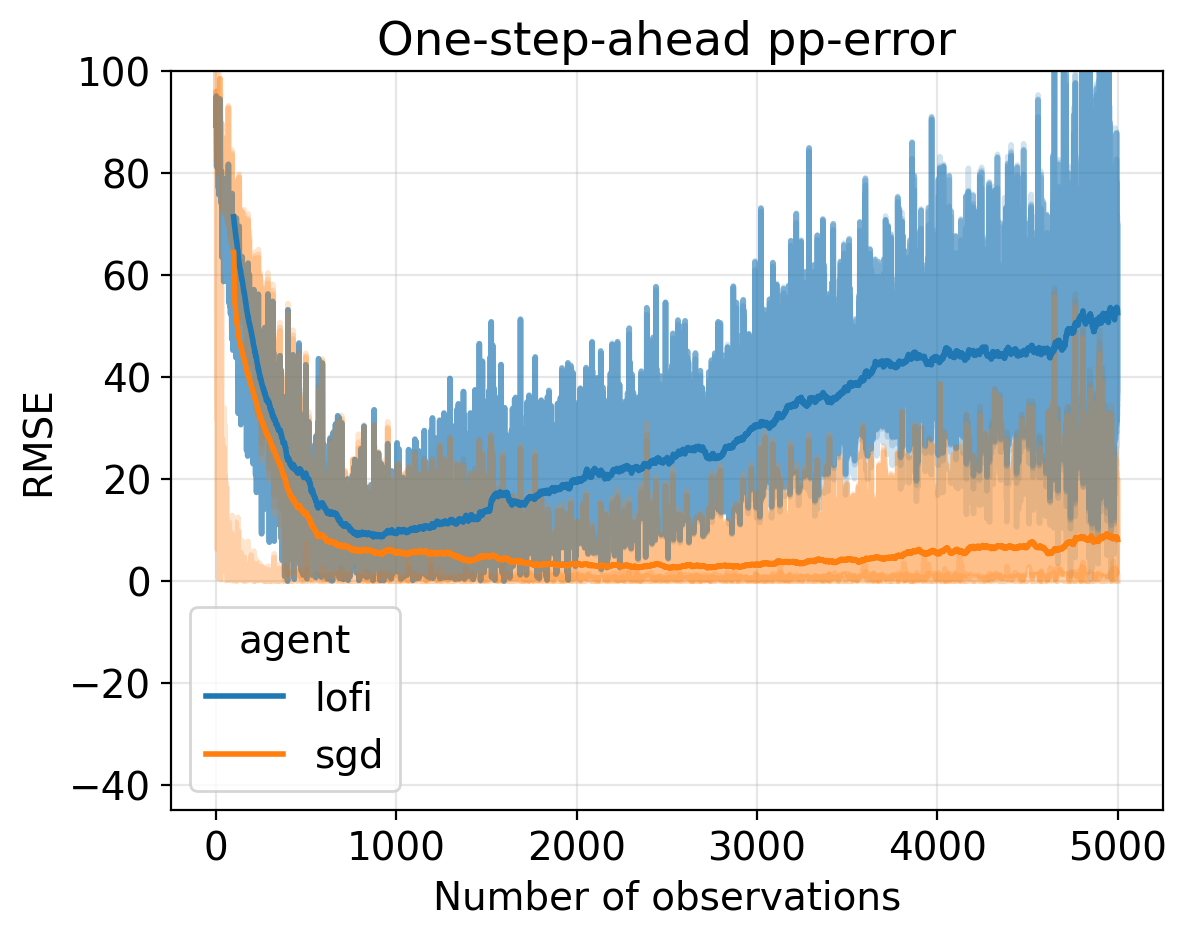

In [66]:
fig, ax = plt.subplots()
for rank in rank_unique:
    (data
     .query("rank == @rank")
     .pivot_table(index="n_obs", columns="agent", values="rmse")
    ).plot(legend=False, alpha=0.2, ax=ax, color=colors)
    
(
    data
    .pivot_table(index="n_obs", columns="agent", values="rmse")
    .rolling(100).mean()
    .plot(ax=ax, color=colors)
)
# ax.set_ylim(40, 100)
ax.grid(alpha=0.3)
ax.set_xlabel("Number of observations")
ax.set_ylabel("RMSE")
ymin, _ = plt.ylim()
plt.ylim(ymin, 100)
plt.title("One-step-ahead pp-error")
# plt.savefig(f"output/images/{dataset_name}-hist-test-rmse.pdf")

<AxesSubplot: xlabel='n_obs'>

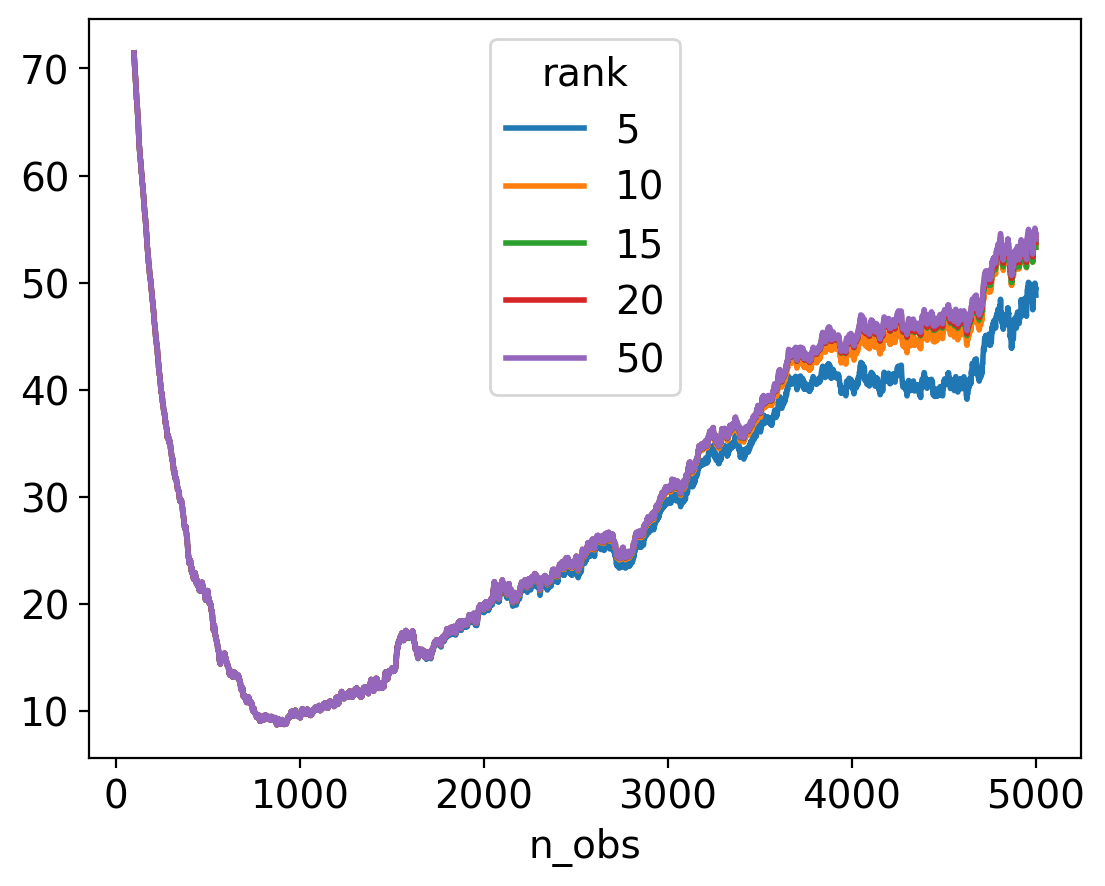

In [65]:
(
    data.query("agent == 'lofi'")
    .pivot_table(index="n_obs", columns="rank", values="rmse")
    .rolling(100).mean()
    .plot()
)